In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import datetime
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import scipy
from scipy import sparse


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/sentiment analysis")

In [ ]:
data=pd.read_csv("df_preprocessed_nw")
data=data.sort_values(by="dates")
data

,Unnamed: 0,Unnamed: 0.1,dates,reviews,reviews.doRecommend,y,polarity
0,16016,16016,2017-03-04 10:47:59.786,great great great great kids play easy monitor...,1,1,0.588889
1,16009,16009,2017-03-04 10:47:59.786,not meet needs not meet needs not meet needs n...,0,0,-0.250000
2,16010,16010,2017-03-04 10:47:59.786,great kids great kids great kids easy little o...,1,1,0.574306
3,16011,16011,2017-03-04 10:47:59.786,kid loves kid loves kid loves great tablet ...,1,1,0.393519
4,16015,16015,2017-03-04 10:47:59.786,great computer great computer great computer ...,1,1,0.625000
...,...,...,...,...,...,...,...
33776,29293,29293,2018-04-28 00:00:00.000,not satisfied sound loses bluetooth connec...,1,0,-0.050000
33777,29413,29413,2018-04-28 00:00:00.000,nice portable speaker alexa nice portable spea...,1,1,0.510000
33778,29469,29469,2018-04-28 00:00:00.000,difficult figure difficult figure difficult fi...,0,0,-0.233333
33779,29548,29548,2018-04-28 00:00:00.000,hands free hands free hands free echo not upda...,1,0,0.308333


Since we need to do time based split, we use numpy.split() and spit first 67% data into train and remaining 33% as test data

In [ ]:
 
train, test= np.split(data, [int(.67 *len(data))])

In [ ]:
print(train.shape)
train

(22633, 7)


,Unnamed: 0,Unnamed: 0.1,dates,reviews,reviews.doRecommend,y,polarity
0,16016,16016,2017-03-04 10:47:59.786,great great great great kids play easy monitor...,1,1,0.588889
1,16009,16009,2017-03-04 10:47:59.786,not meet needs not meet needs not meet needs n...,0,0,-0.250000
2,16010,16010,2017-03-04 10:47:59.786,great kids great kids great kids easy little o...,1,1,0.574306
3,16011,16011,2017-03-04 10:47:59.786,kid loves kid loves kid loves great tablet ...,1,1,0.393519
4,16015,16015,2017-03-04 10:47:59.786,great computer great computer great computer ...,1,1,0.625000
...,...,...,...,...,...,...,...
22888,20754,20754,2017-08-31 00:00:00.000,best kindle ever best kindle ever best kindle ...,1,1,0.816667
22889,20753,20753,2017-08-31 00:00:00.000,fantastic reader fantastic reader fantastic ...,1,1,0.388095
22890,20751,20751,2017-08-31 00:00:00.000,nice easy read good lighting nice easy read go...,1,1,0.439669
22891,20750,20750,2017-08-31 00:00:00.000,awesome reader awesome reader awesome reader l...,1,1,0.492803


In [ ]:
print(test.shape)
test.tail()

(11149, 7)


,Unnamed: 0,Unnamed: 0.1,dates,reviews,reviews.doRecommend,y,polarity
33776,29293,29293,2018-04-28 00:00:00.000,not satisfied sound loses bluetooth connec...,1,0,-0.050000
33777,29413,29413,2018-04-28 00:00:00.000,nice portable speaker alexa nice portable spea...,1,1,0.510000
33778,29469,29469,2018-04-28 00:00:00.000,difficult figure difficult figure difficult fi...,0,0,-0.233333
33779,29548,29548,2018-04-28 00:00:00.000,hands free hands free hands free echo not upda...,1,0,0.308333
33781,29106,29106,2018-04-28 00:00:00.000,portable portable portable wanted portable spe...,0,1,0.320476


Now the features we consider for modeling are: reviews, reviews.dorecommend, polarity and the y values

### Featurization of text data using tfidf weighted Glove vector method

In [ ]:
tfidf_model=TfidfVectorizer()
tfidf_model.fit(train["reviews"])
tfidf_words=tfidf_model.get_feature_names()
tfidf_dict=dict(zip(tfidf_model.get_feature_names(),list(tfidf_model.idf_)))

In [ ]:
embeddings_index=dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")

Done


In [ ]:
glove_words=embeddings_index.keys()


In [ ]:
def tfw2vec(X):
  tfidf_w2v_vectors = []
  for sentence in X: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0 # num of words with a valid vector in the sentence/revie
    for word in sentence.split(): # for each word in a review/sentence
      if (word in glove_words) and (word in tfidf_words):
        vec = embeddings_index.get(word) # getting the vector for each word 
        # here we are multiplying idf value(dictionary[word]) and the tf valu
        tf_idf = tfidf_dict[word]*(sentence.count(word)/len(sentence.split()))
        vector += (vec * tf_idf) # calculating tfidf weighted w2v

        tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
      vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors 
  

In [ ]:
train_text=tfw2vec(train["reviews"].values)

In [ ]:
test_text=tfw2vec(test["reviews"].values) 

In [ ]:
train_text=np.array(train_text)
test_text=np.array(test_text) 

In [ ]:
print(train_text.shape)
print(test_text.shape) 

(22633, 300)
(11149, 300)


In [ ]:
train["polarity"].values.reshape(-1,1).shape 

(22633, 1)

In [ ]:
#now we merge the text features, polarity and do.recommend feature into x
from scipy.sparse import hstack

X_train=np.hstack((train_text,train["polarity"].values.reshape(-1,1),train["reviews.doRecommend"].values.reshape(-1,1)))
X_test=np.hstack((test_text,test["polarity"].values.reshape(-1,1),test["reviews.doRecommend"].values.reshape(-1,1)))
y_train=train["y"].values
y_test=test["y"].values
print(X_train.shape)
print(X_test.shape)

(22633, 302)
(11149, 302)


We need to check the distribution of classes in train and test

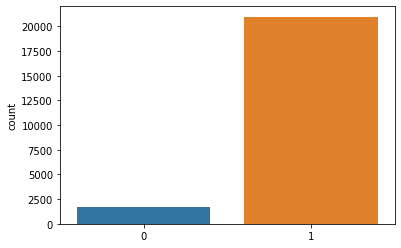

In [ ]:
sns.countplot(y_train)

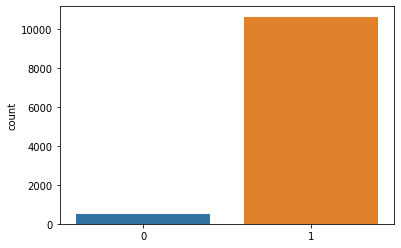

In [ ]:
sns.countplot(y_test)

The distribution of classes is similar in both train and test data.

### Modelling

In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred_train=model.predict(X_train)

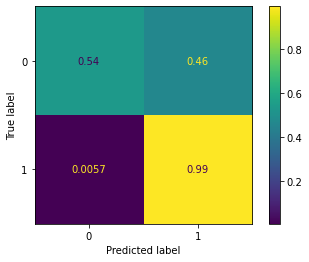

In [ ]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train,normalize="true") 

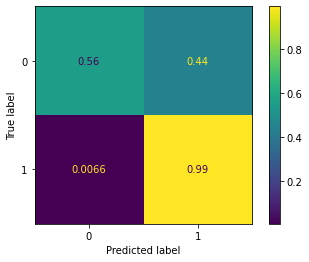

In [ ]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,normalize="true") 

We can see that for the positive class points, the model is predicting the class well. But there is problem while predicting the minority class


Now let's check the performance of the model using data balancing

In [ ]:
model=LogisticRegression(class_weight="balanced")
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

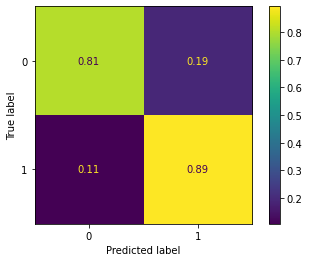

In [ ]:
#confusion matrxi for train data
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train,normalize="true") 

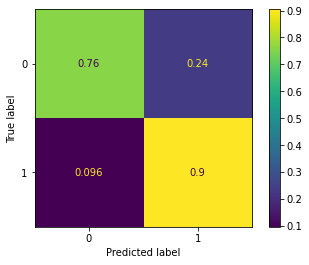

In [ ]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(model, X_test, y_test,normalize="true") 

**Observations from logistic regression model:** 

We can see that performance is improved with data balancing

But, the performance using Approach 1 was better as compared to Glove vector approach

### Model 2- XGBoost

In [ ]:
import xgboost
from xgboost import XGBClassifier

In [ ]:
model3=XGBClassifier()


In [ ]:
#hyperparameter tuning using gridsearch
from sklearn.model_selection import GridSearchCV

In [ ]:

max_depth=[1,2,4,6]
n_estimators=[10,50,100,150,200]
params = {'max_depth': [1,2,4,6],'n_estimators': [10,50,100,150,200]}
best_model=GridSearchCV(model3,params,cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1,verbose=1)

In [ ]:
best_model.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 27.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6],
                         'n_estimators': [10, 50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_tra

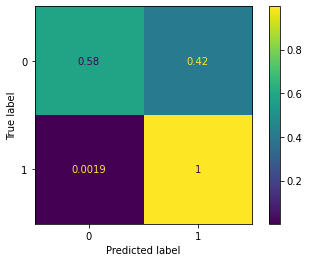

In [ ]:

sklearn.metrics.plot_confusion_matrix(best_model, X_train, y_train,normalize="true") 

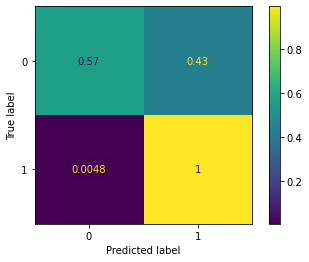

In [ ]:
#confusion matrxi for test data
sklearn.metrics.plot_confusion_matrix(best_model, X_test, y_test,normalize="true") 

**OBSERVTIONS FROM APPROACH 2**
The glove vector featurization did not provide a better result when comapred to tfidf method. This might be because the Glove vectors are preatrained on some other data and it is mostly used in cases where we need to preserve the semantic similarity of sentences